#Install Packages

In [3]:
pip install wfdb tslearn fastdtw

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#Functions

In [4]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Define the filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=3):  # decrease the order
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, padlen=15)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#Load Dataset

In [16]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This is the path and name of your file without the extensions
record_name = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/s1_sit'

# Load the record
record = wfdb.rdrecord(record_name)

# To load annotations
annotation = wfdb.rdann(record_name, 'atr')

#Pre-processing

##Electrocardiogram

In [11]:
# Apply the filter
lowcut = 0.5
highcut = 50
fs = 500 # your sampling rate
ecg_index = record.sig_name.index('ecg')
ecg_signal = record.p_signal[:, ecg_index]

filtered_ecg_signal = butter_bandpass_filter(ecg_signal, lowcut, highcut, fs)

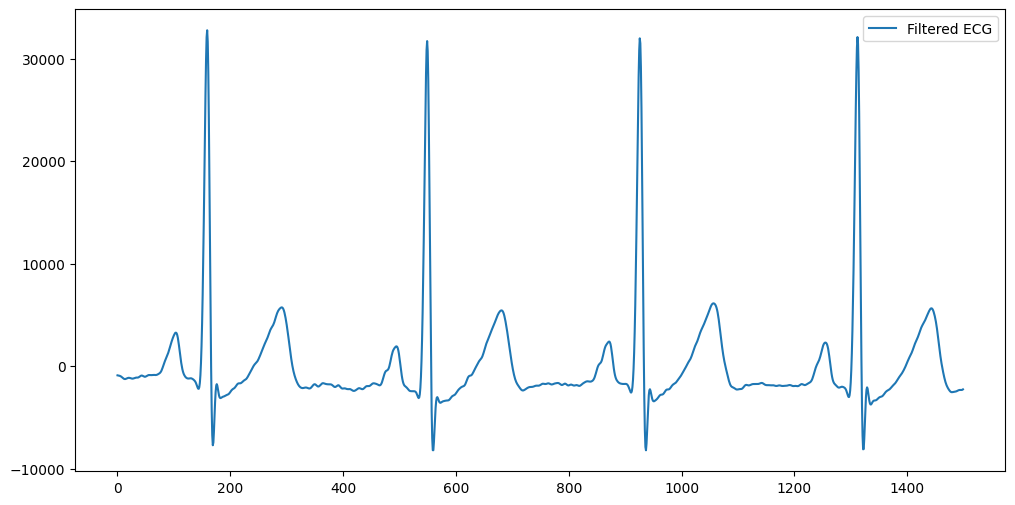

In [20]:
# Select the time range: from 0 to 5 sec. Since fs = 500, this corresponds to the first 2500 data points
time_range_sec = 3
start_point = 0  # starting sample
end_point = time_range_sec * fs  # ending sample

# Get the segment of the signal
segment_ecg_signal = filtered_ecg_signal[start_point : end_point]

# Plot the segment of the signal
plt.figure(figsize=(12, 6))
plt.plot(segment_ecg_signal, label='Filtered ECG')
plt.legend()
plt.show()

##Temperature

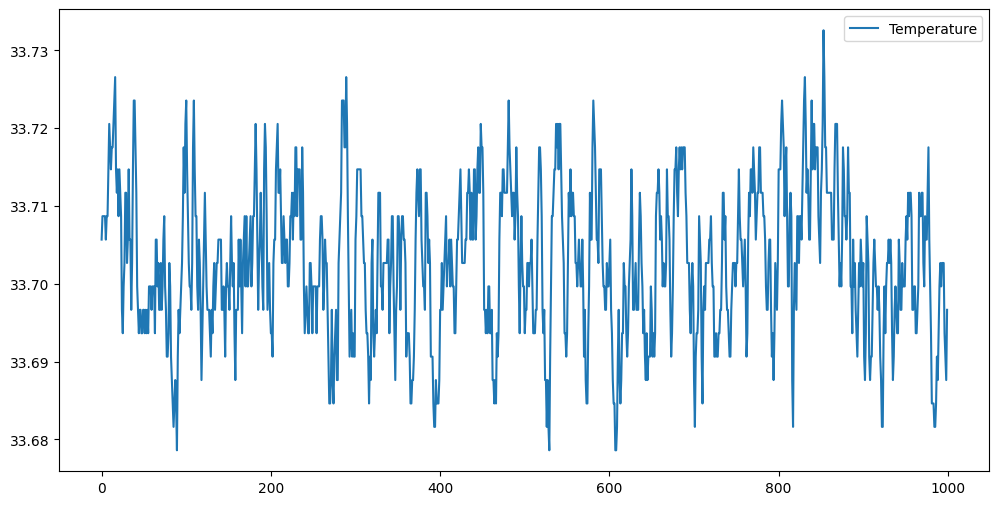

In [21]:
# Apply the filter
lowcut = 0.5
highcut = 50
fs_temp = 500 # your sampling rate
temp_index = record.sig_name.index('temp_3')
temp_signal = record.p_signal[:, temp_index]

filtered_temp_signal = butter_bandpass_filter(ecg_signal, lowcut, highcut, fs_temp)
time_range_sec_temp = 2
start_point_temp = 0  # starting sample
end_point_temp = time_range_sec_temp * fs_temp  # ending sample

# Get the segment of the signal
segment_temp_signal = temp_signal[start_point_temp : end_point_temp]

# Plot the segment of the signal
plt.figure(figsize=(12, 6))
plt.plot(segment_temp_signal, label='Temperature')
plt.legend()
plt.show()

##Photoplethsmography

In [22]:
#red wavelength
pleth_1_index = record.sig_name.index('pleth_1')
pleth_1_signal = record.p_signal[:, pleth_1_index]

#infrared wavelength
pleth_2_index = record.sig_name.index('pleth_2')
pleth_2_signal = record.p_signal[:, pleth_2_index]

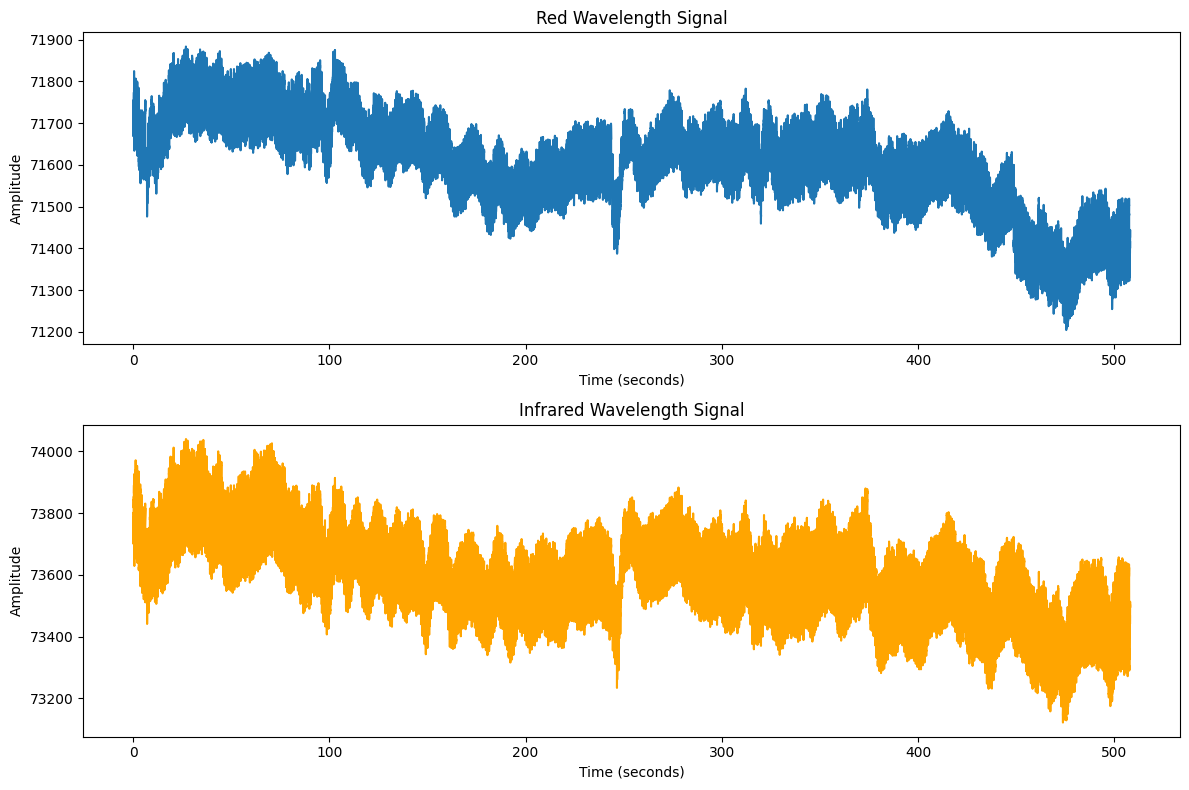

In [23]:
# create time variable for x-axis
time = np.arange(len(pleth_1_signal)) / 500  # Assuming your sampling rate is 500 Hz

plt.figure(figsize=(12, 8))

# plot pleth_1_signal
plt.subplot(2, 1, 1)
plt.plot(time, pleth_1_signal)
plt.title('Red Wavelength Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# plot pleth_2_signal
plt.subplot(2, 1, 2)
plt.plot(time, pleth_2_signal, color='orange')
plt.title('Infrared Wavelength Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

###Calculate Spo2 Signal (Instantaneous)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pleth_1_signal_normalized = scaler.fit_transform(pleth_1_signal.reshape(-1, 1)).flatten()
pleth_2_signal_normalized = scaler.fit_transform(pleth_2_signal.reshape(-1, 1)).flatten()

In [25]:
# Apply the bandpass filter to get the AC component
red_ac = bandpass_filter(pleth_1_signal_normalized, lowcut=0.1, highcut=4, fs=500)
ir_ac = bandpass_filter(pleth_2_signal_normalized, lowcut=0.5, highcut=3, fs=500)

# Apply the lowpass filter to get the DC component
red_dc = lowpass_filter(pleth_1_signal_normalized, cutoff=0.5, fs=500)
ir_dc = lowpass_filter(pleth_2_signal_normalized, cutoff=0.5, fs=500)

# Calculate the ratio of AC to DC for each wavelength
red_ratio = np.mean(np.abs(red_ac)) / (np.mean(np.abs(red_dc)) + 1e-10)
ir_ratio = np.mean(np.abs(ir_ac)) / (np.mean(np.abs(ir_dc)) + 1e-10)

# Estimate SpO2 (using a typical calibration equation, actual calibration might differ)
spo2 = 110 - 25 * (red_ratio / ir_ratio)

print("Estimated SpO2: ", spo2)

Estimated SpO2:  93.57164699481095


###Calculate Spo2 Signal (Timeseries)

In [26]:
def estimate_spo2(red_signal, ir_signal, fs=500):
    """Estimate SpO2 from red and infrared PPG signal segment."""

    # normalize the signals
    red_signal_norm = (red_signal - np.min(red_signal)) / (np.max(red_signal) - np.min(red_signal))
    ir_signal_norm = (ir_signal - np.min(ir_signal)) / (np.max(ir_signal) - np.min(ir_signal))

    # bandpass filter parameters
    lowcut = 0.5  # 0.5 Hz ~ 30 bpm
    highcut = 3.5  # 3.5 Hz ~ 210 bpm

    # apply bandpass filter to the signals
    red_signal_filtered = bandpass_filter(red_signal_norm, lowcut, highcut, fs)
    ir_signal_filtered = bandpass_filter(ir_signal_norm, lowcut, highcut, fs)

    # calculate the AC and DC components of the signals
    red_dc = np.mean(red_signal_filtered)
    red_ac = np.sqrt(np.mean(np.square(red_signal_filtered)) - np.square(red_dc))
    ir_dc = np.mean(ir_signal_filtered)
    ir_ac = np.sqrt(np.mean(np.square(ir_signal_filtered)) - np.square(ir_dc))

    # calculate R, the ratio of AC/DC components
    r = (red_ac / red_dc) / (ir_ac / ir_dc)

    # calculate SpO2
    spo2 = 110 - 25 * r

    return spo2

In [27]:
window_size = 500  # size of the window for the rolling calculation, here it's 500 data points which is 1 second at 500 Hz

# Create empty lists to hold the calculated SpO2 values
spO2_list = []

# Perform rolling calculation of SpO2
for i in range(window_size, len(pleth_1_signal)):
    # Get one-second segment of the signals
    red_signal_segment = pleth_1_signal[i-window_size:i]
    ir_signal_segment = pleth_2_signal[i-window_size:i]

    # Estimate SpO2 for this segment and append to list
    spO2_estimate = estimate_spo2(red_signal_segment, ir_signal_segment)
    spO2_list.append(spO2_estimate)

# Convert list to numpy array
spO2_array = np.array(spO2_list)

spO2_array = np.clip(spO2_array, 0, 100)

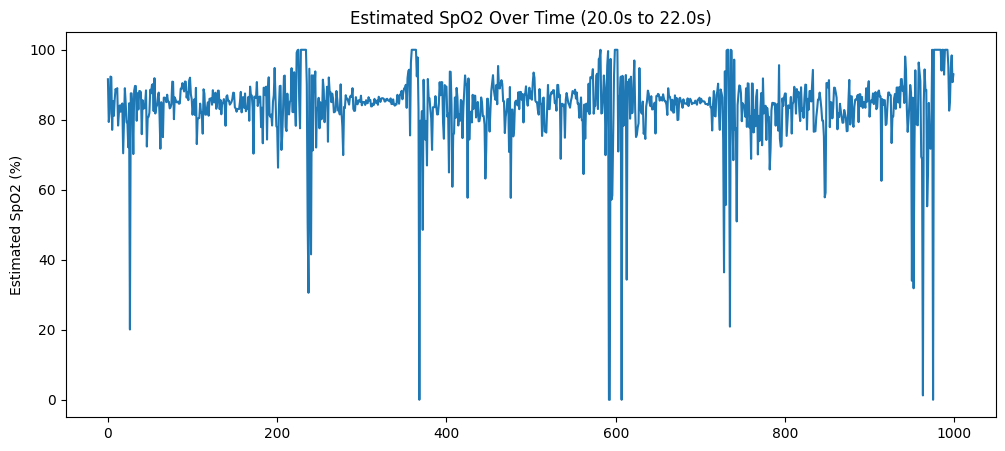

In [30]:
# Start and end indices
fs=500
start_index = 20 * fs  # 20 seconds times 500 samples per second
end_index = start_index + 2 * fs  # 5 seconds times 500 samples per second

# Plot SpO2 over time
plt.figure(figsize=(12, 5))
plt.plot(spO2_array[start_index:end_index])
plt.title('Estimated SpO2 Over Time ({}s to {}s)'.format(start_index/fs, end_index/fs))
#plt.xlabel('Time (s)')
plt.ylabel('Estimated SpO2 (%)')
plt.show()

Standard pulse oximetry typically uses only two wavelengths of light, commonly red and infrared. The principle of operation is that oxygenated and deoxygenated blood absorb light differently at these two wavelengths. By measuring the ratio of absorption at the two wavelengths, the oxygen saturation of the blood (SpO2) can be estimated.

However, some recent developments in pulse oximetry technology have explored the use of additional wavelengths, such as green, to improve the accuracy of SpO2 estimation, particularly in conditions of low perfusion or motion artifact.

It's important to note that to use a third wavelength like green in SpO2 calculation, you would need a more sophisticated model than the basic two-wavelength model used in standard pulse oximetry. This is because the relationship between the absorption of light at three wavelengths and the oxygen saturation becomes more complex.